In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras import Model
# isn't there anything similar from tensorflow? split_dataset (tensorflow.keras.utils) only divides in left and right
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session

In [2]:
# load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split)

In [15]:
#Create a autoencode like in https://blog.keras.io/building-autoencoders-in-keras.html
clear_session()
encoding_dim = 3
inputLayer = Input(shape=(x_train.shape[1],))
encoded = Dense(encoding_dim, activation="relu")(inputLayer) # activity_regularizer=regularizers.l1(10e-5)
decoded = Dense(x_train.shape[1], activation="linear")(encoded)
autoencoder = Model(inputLayer, decoded)
autoencoder.summary()

plot_model(autoencoder)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 3)                 18        
                                                                 
 dense_1 (Dense)             (None, 5)                 20        
                                                                 
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
# Encoder
encoder = Model(inputLayer, encoded)
# Decoder
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))


In [17]:
#Training
#['mean_squared_error', 'mean_absolute_error','mean_squared_logarithmic_error', 'mean_absolute_percentage_error']
autoencoder.compile(optimizer = 'rmsprop', loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])
autoencoder_history = autoencoder.fit(x_train, x_train, epochs=250, batch_size=25, validation_split=0.25)

Epoch 1/250
31/31 [==============================] - 1s 13ms/step - loss: 0.1944 - mean_squared_error: 0.1944 - mean_absolute_error: 0.3003 - val_loss: 0.1803 - val_mean_squared_error: 0.1803 - val_mean_absolute_error: 0.2915
Epoch 2/250
31/31 [==============================] - 0s 5ms/step - loss: 0.1644 - mean_squared_error: 0.1644 - mean_absolute_error: 0.2754 - val_loss: 0.1546 - val_mean_squared_error: 0.1546 - val_mean_absolute_error: 0.2707
Epoch 3/250
31/31 [==============================] - 0s 6ms/step - loss: 0.1408 - mean_squared_error: 0.1408 - mean_absolute_error: 0.2570 - val_loss: 0.1328 - val_mean_squared_error: 0.1328 - val_mean_absolute_error: 0.2526
Epoch 4/250
31/31 [==============================] - 0s 6ms/step - loss: 0.1203 - mean_squared_error: 0.1203 - mean_absolute_error: 0.2399 - val_loss: 0.1133 - val_mean_squared_error: 0.1133 - val_mean_absolute_error: 0.2362
Epoch 5/250
31/31 [==============================] - 0s 6ms/step - loss: 0.1027 - mean_squared_erro

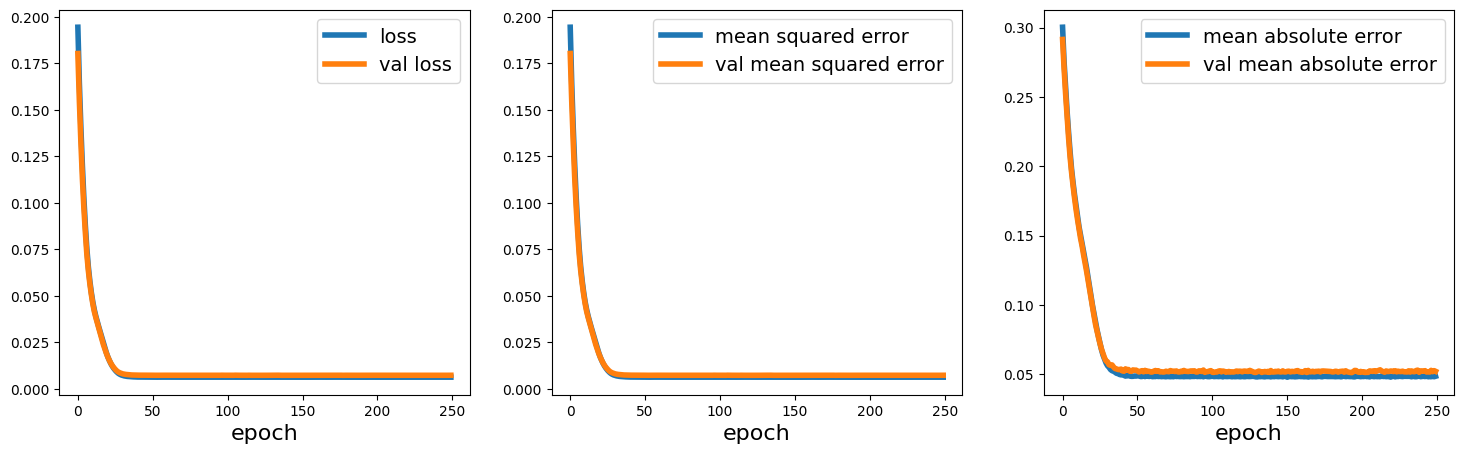

In [18]:
def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(autoencoder_history)

In [19]:
evaluation = autoencoder.evaluate(x_test[:-1], x_test[:-1])
encoded_test = encoder.predict(x_test)
decoded_test = decoder.predict(encoded_test)
print(f'Data: {x_test[0,:]} to be: {encoded_test[0,:]} and rebuilded it to: {decoded_test[0,:]}')

16/16 [==============================] - 0s 2ms/step
Data: [0.19191919 0.5045045  0.09090909 1.         0.23566924] to be: [1.0476718  0.45903766 0.60064423] and rebuilded it to: [0.17980418 0.49496815 0.09323205 1.0021801  0.24007997]
